In [2]:
import json
import numpy as np
import csv
import scipy.stats.distributions
from scipy.spatial.transform import Rotation
import os
from matplotlib import pyplot as plt
import random
import math
import csv

# Helper Functions

### DIspersion filter

In [3]:
def dispersion_filtering(x, y, dispersion_threshold = 6, duraiton_threshold=0.2):
    start = 0
    window = []
    if len(x) == 0:
        return [], []
    fps = int(np.round(1/(x[1] - x[0])))
    duration_threshold_frames = np.ceil(duraiton_threshold * fps)
    
    def dispersion(arr):
        # input is a 2d array
        disp = np.max(arr[:, 0]) - np.min(arr[:, 0]) + np.max(arr[:, 1]) - np.min(arr[:, 1])
        return disp

    fixations = []
    fixations_intervals = []
    
    # while there are still points
    while int(start+duration_threshold_frames) < y.shape[0]:
        # initialize a window:
        window = list(range(int(start), int(start+duration_threshold_frames)))
        start = start + duration_threshold_frames
        disp = dispersion(y[window])
        # while the dispersion is less than the threshold
        while disp <= dispersion_threshold:
            if window[-1]+1 < y.shape[0]:
                window.append(window[-1]+1)
            start = start + 1
            if start >= y.shape[0]:
                break
            disp = dispersion(y[window])

        # if the current set of points never fit the duration criteria
        if len(window) <= duration_threshold_frames:
            start = start + 1
        # otherwise note it as fixations
        else:
            centroid = np.mean(y[window], axis=0)
            duration = (window[-1] - window[0]) / fps
            fixations.append([centroid[0], centroid[1], duration])
            fixations_intervals.append([window[0], window[-1]])
    fixations = np.array(fixations)
    return fixations, fixations_intervals


### Find Head Angle

In [4]:
def get_head_angles(head_dir, target_dir, target_fixations_intervals, target_fixation_duration, persistant_target_angle = 0):
    # find the head fixations that are within the target fixations
    head_fixation_final_val = []
    head_fixations_closest_val = []
    head_fixations_extreme_val = [] # not being used
    head_fixations_value_held = [] # not being used 
    head_fixations_value_held_isValid = [] # not being used
    # find a few head fixations that are within the target fixations
    non_zero_fixation_angles = []
    non_zero_fixation_duration = []
    # find a few head fixations that are within the target fixations
    for i in range(0, len(target_fixations_intervals)):
        angle = target_dir[target_fixations_intervals[i][0]:target_fixations_intervals[i][1], 2].mean()
        if np.abs(angle - persistant_target_angle) > 0:
            non_zero_fixation_angles.append(angle) # this only record non-zero angles
            non_zero_fixation_duration.append(target_fixation_duration[i])
            target_interval = target_fixations_intervals[i]
            start = target_interval[0]
            end = target_interval[1]
            ################# find the head intervals that starts within the target interval, and use average as angle of the head #################
            # intersected = []
            # for j in range(0, len(head_fixations_intervals)):
            #     if head_fixations_intervals[j][0] >= start and head_fixations_intervals[j][0] <= end:
            #         intersected.append(j)
            # # the fixation interval closest to the target interval is selected
            # closest_angle = 10000000
            # closest_index = -100
            # if len(intersected) > 0:
            #     for j in intersected:
            #         head_fixation_value = head_dir[head_fixations_intervals[j][0]:head_fixations_intervals[j][1]][:, 2].mean()
            #         target_angle = target_dir[target_fixations_intervals[i][0]:target_fixations_intervals[i][1]][:, 2].mean()
            #         if np.abs(head_fixation_value - target_angle) < closest_angle:
            #             closest_angle = np.abs(head_fixation_value - target_angle)
            #             closest_index = j
            #     head_fixations_value_held.append(head_dir[head_fixations_intervals[closest_index][0]:head_fixations_intervals[closest_index][1]][:, 2].mean())
            #     head_fixations_value_held_isValid.append(True)
            # else:
            #     head_fixations_value_held.append(head_dir[target_fixations_intervals[i][0]:target_fixations_intervals[i][1]][:, 2].mean())
            #     head_fixations_value_held_isValid.append(False)
            
            ################# find the closest value within the target interval #################
            extreme_value_index = np.argmin(np.abs(head_dir[start:end][:, 2] - angle))
            head_fixations_closest_val.append(head_dir[start:end][:, 2][extreme_value_index])
            # if head_fixations_closest_val[-1] / target_dir[start:end][:, 2].mean() < 0:
            #     print("wrong sign")
            #     continue

            ################# find the extreme value within the target interval #################
            extreme_value_index = np.argmax(np.abs(head_dir[start:end][:, 2]))
            head_fixations_extreme_val.append(head_dir[start:end][:, 2][extreme_value_index])

            ################# find the final value within target interval #################
            head_fixation_final_val.append(head_dir[end][2])
            # plt.plot(head_dir[start:end][:, 0], head_dir[start:end][:, 2], label="head")
            # plt.plot(target_dir[start:end][:, 0], target_dir[start:end][:, 2], label="target")
            # plt.plot(head_dir[start:end][:, 0], np.ones(head_dir[start:end][:, 0].shape) * head_fixations_extreme_val[-1], label="head fixation (from extreme value method)")
            # plt.plot(head_dir[start:end][:, 0], np.ones(head_dir[start:end][:, 0].shape) * head_fixations_value_held[-1], label="head fixation (from value held method)")
            # plt.plot(head_dir[start:end][:, 0], np.ones(head_dir[start:end][:, 0].shape) * head_fixations_closest_val[-1], label="head fixation (from closest value method)")
            # plt.plot(head_dir[start:end][:, 0], np.ones(head_dir[start:end][:, 0].shape) * head_fixation_final_val[-1], label="head fixation (from final value method)")
          
            # plt.legend()
            # plt.show()
        else:
            head_fixations_closest_val.append(persistant_target_angle)
            head_fixations_extreme_val.append(persistant_target_angle)
            head_fixations_value_held.append(persistant_target_angle)
            head_fixations_value_held_isValid.append(False)
            non_zero_fixation_angles.append(persistant_target_angle)
            non_zero_fixation_duration.append(persistant_target_angle)
    
    head_fixations_closest_val = np.array(head_fixations_closest_val)
    head_fixations_extreme_val = np.array(head_fixations_extreme_val)
    head_fixations_value_held = np.array(head_fixations_value_held)
    head_fixations_value_held_isValid = np.array(head_fixations_value_held_isValid)
    head_fixation_final_val = np.array(head_fixation_final_val)
    non_zero_fixation_angles = np.array(non_zero_fixation_angles)
    non_zero_fixation_duration = np.array(non_zero_fixation_duration)
    
    return head_fixations_closest_val, non_zero_fixation_angles, non_zero_fixation_duration

        



### find CHOR

In [5]:
class GaussianKernal:
    def __init__(self, loc, sigma, amplitude):
        self.sigma = sigma
        self.loc = loc
        self.amplitude = amplitude
        self.gaussina = scipy.stats.distributions.norm(loc, sigma)
    def cumulate(self, t_arr, x_arr):
        # t_arr is the time array
        # x_arr is the value array, in which we will cumulate a series of GaussianKernals
        x_arr += self.amplitude * self.gaussina.pdf(t_arr)
        return x_arr

def generate_smooth_distribution(fixation_angles):
    # generate a smooth distribution of the fixation ang
    kernal_list = []
    kernal_std = 3
    kernal_amplitude = 1
    for i in range(len(fixation_angles)):
        kernal_list.append(GaussianKernal(fixation_angles[i], kernal_std, kernal_amplitude))
    t_arr = np.linspace(-100, 100, 1000)
    x_arr = np.zeros(t_arr.shape)
    for kernal in kernal_list:
        x_arr = kernal.cumulate(t_arr, x_arr)
    x_arr = x_arr/np.sum(x_arr)
    return t_arr, x_arr, kernal_list
def generate_CHOR_distribution(head_angles, target_angles, target_angle_distribution):
    # find the closest angle in the target angle distribution for each head angle
    head_kernal_list = []
    for i in range(len(target_angles)):
        closest_target_angle_index = np.argmin(np.abs(target_angle_distribution[0] - target_angles[i]))
        # scaling the amplitude of each head angle by the corresponding target angle distribution
        head_kernal_list.append(GaussianKernal(head_angles[i], 3, 1 / target_angle_distribution[1][closest_target_angle_index]))
    t_arr = np.linspace(-100, 100, 1000)
    x_arr = np.zeros(t_arr.shape)
    for kernal in head_kernal_list:
        x_arr = kernal.cumulate(t_arr, x_arr)
    x_arr = x_arr/np.sum(x_arr)
    # find start and end range that contains 90% of the distribution
    cumulative_x_arr = np.cumsum(x_arr)
    start_index = np.argmin(np.abs(cumulative_x_arr - 0.05))
    end_index = np.argmin(np.abs(cumulative_x_arr - 0.95))
    start_angle = t_arr[start_index]
    end_angle = t_arr[end_index]

    return t_arr, x_arr, start_angle, end_angle

def get_CHOR(fixation_angles, head_fixation_angles, angle_to_ignore=0):
    is_not_zero = np.where(np.abs(fixation_angles-angle_to_ignore) <= 1E-3, False, True)
    # is_not_zero = np.ones(fixation_angles.shape, dtype=bool)
    # is_not_zero = True

    target_angle_distribution = generate_smooth_distribution(fixation_angles[is_not_zero])
    head_angle_distribution = generate_CHOR_distribution(head_fixation_angles[is_not_zero], fixation_angles[is_not_zero], target_angle_distribution)
    CHOR_start, CHOR_end = head_angle_distribution[2], head_angle_distribution[3]
    return CHOR_start, CHOR_end, target_angle_distribution, head_angle_distribution



# Pilot Study stuff

## Plain Symmetry, Zero initial position

In [6]:
INPUT_DIR = "/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_SYMMETRY_0"
dirs = os.listdir(INPUT_DIR)
recording_file_names = ['anchoredDwell_0']
data_types = ["gaze_dir", "head_dir", "head_pos", "target_pos"]
total_length = 0
all_eye_data = []
all_head_data = []
all_target_data = []
all_target_input = []
for fileName in recording_file_names:
    data_type = "gaze_dir"
    fullPath = os.path.join(INPUT_DIR, data_type + "_" + fileName + ".csv")
    eye_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
    
    data_type = "head_dir"
    fullPath = os.path.join(INPUT_DIR, data_type + "_" + fileName + ".csv")
    head_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
    
    data_type = "target_pos"
    fullPath = os.path.join(INPUT_DIR, data_type + "_" + fileName + ".csv")
    target_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
    
    all_eye_data.append(eye_data)
    all_head_data.append(head_data)
    all_target_data.append(target_data)
    
    setupFileName = os.path.join(*[INPUT_DIR, fileName+".json"])
    target_input = json.load(open(setupFileName, "r"))
    all_target_input.append(target_input)
# also load the data generation file


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_12082/1636220942.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)


WilcoxonResult(statistic=578.0, pvalue=0.9230980246766052)


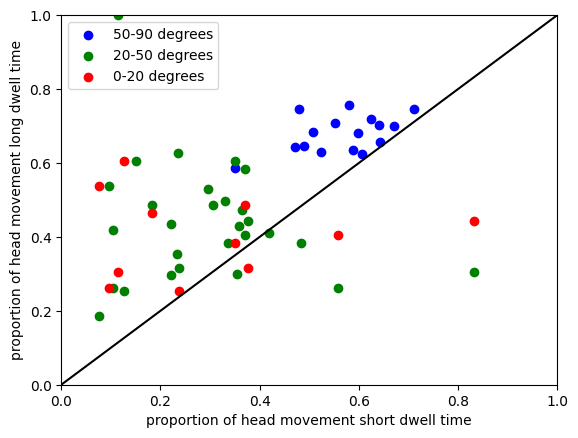

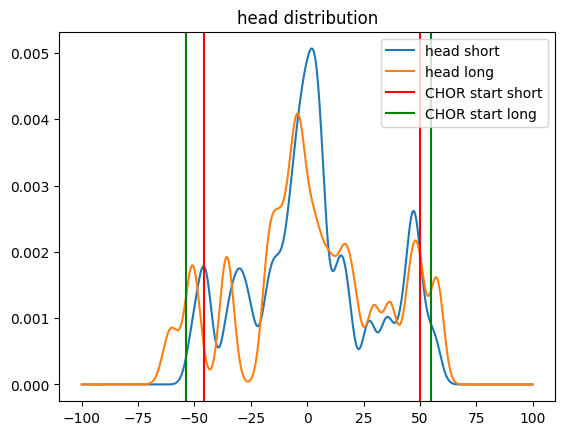

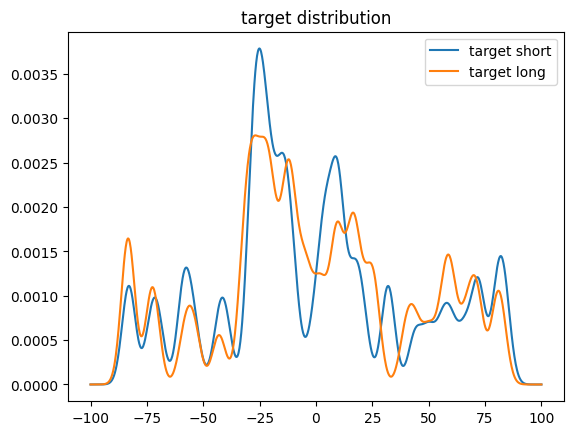

<Figure size 640x480 with 0 Axes>

In [8]:
CHOR_long_List = []
CHOR_short_List = []
head_angle_distributions_short_list = []
head_angle_distributions_long_list = []

dwellTimeTargets = [0]
for cp in [0]:
    head_dir = all_head_data[cp]
    eye_dir = all_eye_data[cp]
    target_pos = all_target_data[cp]
    # prevent the angle from going to 360
    head_dir[:, 1:] = np.where(head_dir[:, 1:] > 180, head_dir[:, 1:] - 360, head_dir[:, 1:]) 
    eye_dir[:, 1:] = np.where(eye_dir[:, 1:] > 180, eye_dir[:, 1:] - 360, eye_dir[:, 1:])     
    
    neutral = np.array([0, 0, -1])
    target_dir = np.zeros(target_pos.shape)
    target_dir[:, 0] = target_pos[:, 0]
    for i in range(target_pos.shape[0]):
        # get the object rotation from scipy
        vec = target_pos[i, 1:]
        vec = vec / np.linalg.norm(vec)
        rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)
        # print(rot_y, target_dir[i, 2])
        target_dir[i, 2] = -rot_y

    # note the dispersion is originally for a 2D input array
    target_fixations, target_fixations_intervals = dispersion_filtering(target_dir[:, 0], target_dir[:, 1:], 0)
    target_fixations_angles = target_fixations[:, 1]
    target_fixation_duration = target_fixations[:, 2]

    # get the combined head and eye angles
    gaze_dir = eye_dir + head_dir
    gaze_fixations, gaze_fixations_intervals = dispersion_filtering(gaze_dir[:, 0], gaze_dir[:, 1:], 2)
    gaze_fixations_angles = gaze_fixations[:, 1]
    gaze_fixation_duration = gaze_fixations[:, 2]

    # get the target durations from the experimental setup file
    target_present_duration = all_target_input[cp]["duration"]
    valid_target_list = np.array(all_target_input[cp]["isTarget"])
    valid_target_list = np.where(valid_target_list==1, True, False)
    target_present_duration = np.array(target_present_duration)
    target_present_duration = target_present_duration[valid_target_list]

    head_fixation_angles, fixation_angles, fixation_duration = get_head_angles(head_dir, target_dir, target_fixations_intervals, target_fixation_duration, persistant_target_angle = dwellTimeTargets[np.maximum(cp-2, 0)])

    sorted_indices = sorted(range(fixation_angles.shape[0]), key=lambda i: fixation_angles[i])

    # Rearrange array2 using the sorted indices
    head_fixation_angles_sorted = np.array([head_fixation_angles[i] for i in sorted_indices])
    fixation_angles_sorted = np.array([fixation_angles[i] for i in sorted_indices])
    fixation_duration_sorted = np.array([fixation_duration[i] for i in sorted_indices])
    target_present_duration_sorted = np.array([target_present_duration[i] for i in sorted_indices])

    is_short = np.where(target_present_duration_sorted < 0.6, True, False)
    is_long = np.where(target_present_duration_sorted >= 0.6, True, False)
    is_not_zero = np.where(np.abs(fixation_angles_sorted - dwellTimeTargets[0]) < 1E-3, False, True)
    is_short_and_is_not_zero = np.logical_and(is_short, is_not_zero)
    is_long_and_is_not_zero = np.logical_and(is_long, is_not_zero)
    CHOR_start_short, CHOR_end_short, target_angle_distribution_short, head_angle_distribution_short = get_CHOR(fixation_angles_sorted[is_short], head_fixation_angles_sorted[is_short], dwellTimeTargets[np.maximum(cp-2, 0)])
    CHOR_start_long, CHOR_end_long, target_angle_distribution_long, head_angle_distribution_long = get_CHOR(fixation_angles_sorted[is_long], head_fixation_angles_sorted[is_long], dwellTimeTargets[np.maximum(cp-2, 0)])
    
    CHOR_long_List.append([CHOR_start_long, CHOR_end_long])
    CHOR_short_List.append([CHOR_start_short, CHOR_end_short])

    head_angle_distributions_short_list.append(head_fixation_angles_sorted[is_short_and_is_not_zero])
    head_angle_distributions_long_list.append(head_fixation_angles_sorted[is_long_and_is_not_zero])

    # wilcoxon test on the head angle distribution for short and long dwell time -> this canot say that the two distributions are the same. We just failed to prove difference. 
    from scipy.stats import wilcoxon
    print(scipy.stats.wilcoxon(head_fixation_angles_sorted[is_short_and_is_not_zero], head_fixation_angles_sorted[is_long_and_is_not_zero]))
    
    # head contribution proportion
    head_contribution_proportion_short = head_fixation_angles_sorted[is_short_and_is_not_zero]/fixation_angles_sorted[is_short_and_is_not_zero]
    head_contribution_proportion_long = head_fixation_angles_sorted[is_long_and_is_not_zero]/fixation_angles_sorted[is_long_and_is_not_zero]
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    is_low_range_short = np.where(np.abs(fixation_angles_sorted[is_short_and_is_not_zero]) <= 20, True, False)
    is_medium_range_short = np.where(np.abs(fixation_angles_sorted[is_short_and_is_not_zero]) <= 50, True, False)
    is_long_range_short = np.where(np.abs(fixation_angles_sorted[is_short_and_is_not_zero]) > 50, True, False)      
    is_low_range_long = np.where(np.abs(fixation_angles_sorted[is_long_and_is_not_zero]) <= 20, True, False)
    is_medium_range_long = np.where(np.abs(fixation_angles_sorted[is_long_and_is_not_zero]) <= 50, True, False)
    is_long_range_long = np.where(np.abs(fixation_angles_sorted[is_long_and_is_not_zero]) > 50, True, False)
    
    plt.scatter(head_contribution_proportion_short[is_long_range_short], head_contribution_proportion_long[is_long_range_long], label="50-90 degrees", color="blue")
    plt.scatter(head_contribution_proportion_short[is_medium_range_short], head_contribution_proportion_long[is_medium_range_long], label="20-50 degrees", color="green")
    plt.scatter(head_contribution_proportion_short[is_low_range_short], head_contribution_proportion_long[is_low_range_long], label="0-20 degrees", color="red")
    

    plt.plot([0, 1], [0, 1], color="black")
    plt.xlabel("proportion of head movement short dwell time")
    plt.ylabel("proportion of head movement long dwell time")
    plt.legend()
    plt.show()

    doPlot = True
    if doPlot:
        plt.figure()
        plt.plot(head_angle_distribution_short[0], head_angle_distribution_short[1], label="head short")
        plt.plot(head_angle_distribution_long[0], head_angle_distribution_long[1], label="head long")
        plt.axvline(CHOR_start_short, color="red", label="CHOR start short")
        plt.axvline(CHOR_end_short, color="red")
        plt.axvline(CHOR_start_long, color="green", label="CHOR start long")
        plt.axvline(CHOR_end_long, color="green")


        plt.legend()
        plt.title("head distribution")
        plt.show()

        plt.figure()
        plt.plot(target_angle_distribution_short[0], target_angle_distribution_short[1], label="target short")
        plt.plot(target_angle_distribution_long[0], target_angle_distribution_long[1], label="target long")
        plt.legend()
        plt.title("target distribution")
        plt.show()
        plt.figure()
    
    

## Symmetry in Persistant Angle

In [559]:
INPUT_DIR = "/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_SYMMETRY_PILOT/collectedData"
dirs = os.listdir(INPUT_DIR)
recording_file_names = ['anchoredDwell_sym_1', 'anchoredDwell_sym_4']
dwellTimeTargets = [20, -20]
comparing = [0, 1]
data_types = ["gaze_dir", "head_dir", "head_pos", "target_pos"]

total_length = 0
all_eye_data = []
all_head_data = []
all_target_data = []
all_target_input = []
for fileName in recording_file_names:
    data_type = "gaze_dir"
    fullPath = os.path.join(INPUT_DIR, data_type + "_" + fileName + ".csv")
    eye_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
    
    data_type = "head_dir"
    fullPath = os.path.join(INPUT_DIR, data_type + "_" + fileName + ".csv")
    head_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
    
    data_type = "target_pos"
    fullPath = os.path.join(INPUT_DIR, data_type + "_" + fileName + ".csv")
    target_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
    
    all_eye_data.append(eye_data)
    all_head_data.append(head_data)
    all_target_data.append(target_data)
    
    setupFileName = os.path.join(*[INPUT_DIR, fileName+".json"])
    target_input = json.load(open(setupFileName, "r"))
    all_target_input.append(target_input)
    # display something
    trial_length = eye_data[-1,0] - eye_data[0, 0]
    total_length += trial_length
    print("Trial {} took {} minutes".format(fileName, trial_length/60))
print("total time took {} minutes".format(total_length / 60))

# also load the data generation file


Trial anchoredDwell_sym_1 took 3.2972153333333334 minutes
Trial anchoredDwell_sym_4 took 3.4605316666666672 minutes
total time took 6.757747 minutes


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_56521/279517047.py:26: RuntimeWarning: divide by zero encountered in double_scalars
  rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_56521/279517047.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)


CHOR for left side is:  -47.147147147147145 59.35935935935936
CHOR for right side is:  -45.14514514514514 65.36536536536536
[ 1.592905e+01 -4.578590e+01  1.931133e+01  3.507966e+01  1.992904e+01
 -4.638660e+01  1.756509e+01  2.782006e+01  1.979688e+01  4.136985e-01
  2.054912e+01  4.525715e+01  2.000274e+01  3.013853e+01  2.039493e+01
  2.584685e+01  2.003848e+01 -3.033310e+01  1.353969e+01  3.945724e+01
  1.990816e+01  3.587333e+01  1.978158e+01 -3.221560e+01  1.366704e+01
 -7.701100e+00  1.845121e+01  5.275555e+01  2.333788e+01  4.750427e+00
  1.986949e+01  4.902401e+01  2.218151e+01 -9.213000e+00  1.753102e+01
 -3.842560e+01  1.980416e+01 -3.208030e+01  1.929851e+01  6.932512e+00
  1.996779e+01  7.742031e-01  1.693846e+01  4.563734e+01  1.989595e+01
  2.793793e+01  2.015423e+01  1.456306e+01  1.977604e+01  7.150707e+00
  1.601708e+01 -2.921830e+01  1.777441e+01  5.394218e+01  1.979891e+01
 -3.652880e+01  1.342280e+01  3.625462e+00  1.980176e+01  3.059256e+01
  1.981775e+01  1.067396

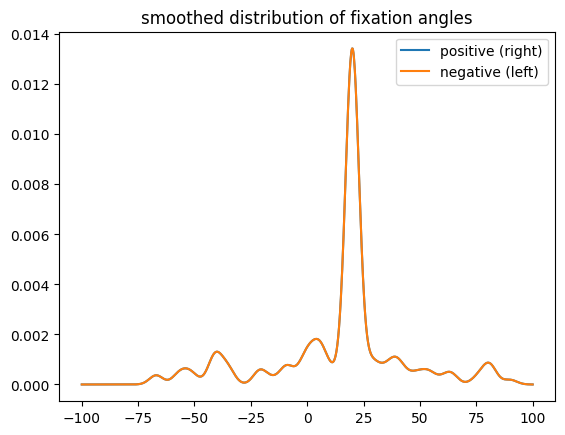

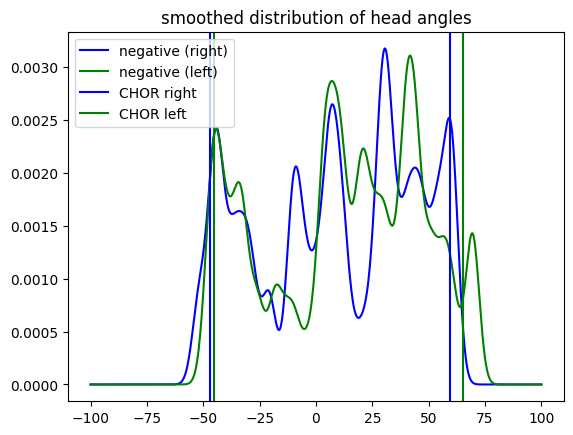

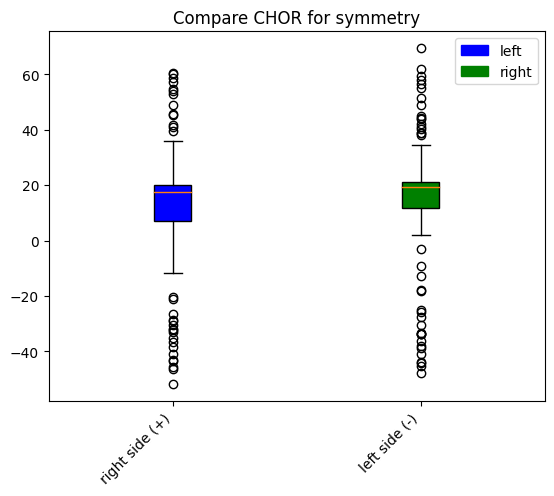

In [560]:
comparison_pairs = [[0, 1]]
for cp in comparison_pairs:
    pair1 = cp[0]
    pair2 = cp[1]

    head_dir1 = all_head_data[pair1]
    eye_dir1 = all_eye_data[pair1]
    target_pos1 = all_target_data[pair1]

    head_dir2 = all_head_data[pair2]
    eye_dir2 = all_eye_data[pair2]
    target_pos2 = all_target_data[pair2]

    # prevent the angle from going to 360
    head_dir1[:, 1:] = np.where(head_dir1[:, 1:] > 180, head_dir1[:, 1:] - 360, head_dir1[:, 1:])
    head_dir2[:, 1:] = np.where(head_dir2[:, 1:] > 180, head_dir2[:, 1:] - 360, head_dir2[:, 1:])

    # compute target direction in term of angles
    neutral = np.array([0, 0, -1])
    target_dir1 = np.zeros(target_pos1.shape)
    target_dir1[:, 0] = target_pos1[:, 0]
    for i in range(target_pos1.shape[0]):
        # get the object rotation from scipy
        vec = target_pos1[i, 1:]
        vec = vec / np.linalg.norm(vec)
        rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)
        # print(rot_y, target_dir[i, 2])
        target_dir1[i, 2] = -rot_y

    target_dir2 = np.zeros(target_pos2.shape)
    target_dir2[:, 0] = target_pos2[:, 0]
    for i in range(target_pos2.shape[0]):
        # get the object rotation from scipy
        vec = target_pos2[i, 1:]
        vec = vec / np.linalg.norm(vec)
        rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)
        # print(rot_y, target_dir[i, 2])
        target_dir2[i, 2] = -rot_y

    # note the dispersion is originally for a 2D input array
    target_fixations1, target_fixations_intervals1 = dispersion_filtering(target_dir1[:, 0], target_dir1[:, 1:], 0)
    target_fixations_angles1 = target_fixations1[:, 1]
    target_fixation_duration1 = target_fixations1[:, 2]

    target_fixations2, target_fixations_intervals2 = dispersion_filtering(target_dir2[:, 0], target_dir2[:, 1:], 0)
    target_fixations_angles2 = target_fixations2[:, 1]
    target_fixation_duration2 = target_fixations2[:, 2]

    # get the combined head and eye angles
    gaze_dir1 = eye_dir1 + head_dir1
    gaze_fixations1, gaze_fixations_intervals1 = dispersion_filtering(gaze_dir1[:, 0], gaze_dir1[:, 1:], 2)
    gaze_fixations_angles1 = gaze_fixations1[:, 1]
    gaze_fixation_duration1 = gaze_fixations1[:, 2]

    gaze_dir2 = eye_dir2 + head_dir2
    gaze_fixations2, gaze_fixations_intervals2 = dispersion_filtering(gaze_dir2[:, 0], gaze_dir2[:, 1:], 2)
    gaze_fixations_angles2 = gaze_fixations2[:, 1]
    gaze_fixation_duration2 = gaze_fixations2[:, 2]
    
    # get the target durations from the experimental setup file
    target_present_duration1 = all_target_input[pair1]["duration"]
    valid_target_list1 = np.array(all_target_input[pair1]["isTarget"])
    valid_target_list1 = np.where(valid_target_list1==1, True, False)
    target_present_duration1 = np.array(target_present_duration1)
    target_present_duration1 = target_present_duration1[valid_target_list1]

    target_present_duration2 = all_target_input[pair2]["duration"]
    valid_target_list2 = np.array(all_target_input[pair2]["isTarget"])
    valid_target_list2 = np.where(valid_target_list2==1, True, False)
    target_present_duration2 = np.array(target_present_duration2)
    target_present_duration2 = target_present_duration2[valid_target_list2]

    # get the head angles
    head_fixation_angles1, fixation_angles1, fixation_duration1 = get_head_angles(head_dir1, target_dir1, target_fixations_intervals1, target_fixation_duration1, persistant_target_angle = dwellTimeTargets[np.maximum(pair1-2, 0)])
    head_fixation_angles2, fixation_angles2, fixation_duration2 = get_head_angles(head_dir2, target_dir2, target_fixations_intervals2, target_fixation_duration2, persistant_target_angle = dwellTimeTargets[np.maximum(pair2-2, 0)])    
    positive_head_fixation_angles2, positive_fixation_angles2 = -head_fixation_angles2, -fixation_angles2

    # compare the positive and negative distributions
    distriburion_1 = generate_smooth_distribution(fixation_angles1)
    distriburion_2 = generate_smooth_distribution(positive_fixation_angles2)
    
    distriburion_1_CHOR = get_CHOR(fixation_angles1, head_fixation_angles1, dwellTimeTargets[np.maximum(pair1-2, 0)])
    distriburion_2_CHOR = get_CHOR(positive_fixation_angles2, positive_head_fixation_angles2, -dwellTimeTargets[np.maximum(pair2-2, 0)])

    print("CHOR for left side is: ", distriburion_1_CHOR[0], distriburion_1_CHOR[1])
    print("CHOR for right side is: ", distriburion_2_CHOR[0], distriburion_2_CHOR[1])

    # compute probaiblity of gaze fixation angle:
    head_proportions_1 = (head_fixation_angles1 - 20) / (fixation_angles1 - 20)
    print(head_fixation_angles1)
    head_movement_probability_1 = np.where(head_proportions_1 >= 0.1, 1, 0).mean()
    head_proportions_2 = (positive_head_fixation_angles2 - 20) / (positive_fixation_angles2 - 20)
    head_movement_probability_2 = np.where(head_proportions_2 >= 0.1, 1, 0).mean()

    print('the probability of head movement for left side is: ', head_movement_probability_1)
    print('the probability of head movement for right side is: ', head_movement_probability_2)

    # compute wilcoxon test
    from scipy.stats import wilcoxon
    print("the result for fixation angle is:", scipy.stats.wilcoxon(fixation_angles1, positive_fixation_angles2))
    print("the result for head fixation angle is:", scipy.stats.wilcoxon(head_fixation_angles1, positive_head_fixation_angles2))

    

    plt.plot(distriburion_1[0], distriburion_1[1], label="positive (right)")
    plt.plot(distriburion_2[0], distriburion_2[1], label="negative (left)")
    plt.legend()
    plt.title("smoothed distribution of fixation angles")
    plt.show()

    plt.plot(distriburion_1_CHOR[3][0], distriburion_1_CHOR[3][1], color="blue", label="negative (right)")
    plt.plot(distriburion_2_CHOR[3][0], distriburion_2_CHOR[3][1], color="green", label="negative (left)")
    plt.axvline(distriburion_1_CHOR[0], color="blue", label="CHOR right")
    plt.axvline(distriburion_1_CHOR[1], color="blue")
    plt.axvline(distriburion_2_CHOR[0], color="green", label="CHOR left")
    plt.axvline(distriburion_2_CHOR[1], color="green")

    plt.legend()
    plt.title("smoothed distribution of head angles")
    plt.show()

    # plot box plot
    is_not_zero1 = np.where(np.abs(fixation_angles1 - dwellTimeTargets[pair1]) < 1E-3, False, True)
    is_not_zero2 = np.where(np.abs(fixation_angles2 - dwellTimeTargets[pair2]) < 1E-3, False, True)

    combined_data = [head_fixation_angles1, positive_head_fixation_angles2]
    long_dwell_title = ["right side (+)"]
    short_dwell_title = ["left side (-)"]
    combined_labels = [label for label_pair in zip(long_dwell_title, short_dwell_title) for label in label_pair]

    # Customize the box colors
    colors = ['blue', 'green']  # You can customize the colors
    box = plt.boxplot(combined_data, labels=combined_labels, patch_artist=True)
    for boxplot, color in zip(box['boxes'], colors * len(fixation_angles1)):
        boxplot.set_facecolor(color)

    # Create a legend
    legend_labels = ['left', 'right']
    legend_patches = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
    plt.legend(legend_patches, legend_labels)
    # plt.xlabel('Data')
    # plt.ylabel('Value')
    plt.title('Compare CHOR for symmetry')

    # Rotate the x-axis labels for better visibility
    plt.xticks(rotation=45, ha='right')

    # Show the plot
    plt.show()

    # perform statistical test on the range of the CHOR
    # get the range of the CHOR
    CHOR_range1 = np.abs(distriburion_1_CHOR[0] - distriburion_1_CHOR[1])
    CHOR_range2 = np.abs(distriburion_2_CHOR[0] - distriburion_2_CHOR[1])

## ANOVA Symmetry in persistent angle 

In [40]:
input_dirs = ["/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_BINGJIAN/collectedData",
              "/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_LIPAN/collectedData",
              "/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_BOGDAN/collectedData"]

comparison_CHOR_L = []
comparison_CHOR_R = []
comparison_head_prob = []
for input_dir in input_dirs:
    print(input_dir)
    dirs = os.listdir(input_dir)
    recording_file_names = ['randomCalibration', 'RandomPositions', 'anchoredDwell_0', 'anchoredDwell_1', 'anchoredDwell_2', 'anchoredDwell_3', 'anchoredDwell_4', 'anchoredDwell_5', 'anchoredDwell_6']
    dwellTimeTargets = [0, 20, 40, 60, -20, -40, -60]
    comparing = [2,3,4,5,6,7,8]
    # recording_file_names = ['randomCalibration', 'RandomPositions', 'anchoredDwell_0', 'anchoredDwell_2', 'anchoredDwell_3', 'anchoredDwell_4', 'anchoredDwell_5', 'anchoredDwell_6']
    # dwellTimeTargets = [0, 40, 60, -20, -40, -60]
    # comparing = [2,3,4,5,6,7]
    data_types = ["gaze_dir", "head_dir", "head_pos", "target_pos"]
    # get duration of each trial:


    total_length = 0
    all_eye_data = []
    all_head_data = []
    all_target_data = []
    all_target_input = []
    for fileName in recording_file_names:
        data_type = "gaze_dir"
        fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
        eye_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
        
        data_type = "head_dir"
        fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
        head_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
        
        data_type = "target_pos"
        fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
        target_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
        
        all_eye_data.append(eye_data)
        all_head_data.append(head_data)
        all_target_data.append(target_data)
        
        setupFileName = os.path.join(*[input_dir, fileName+".json"])
        target_input = json.load(open(setupFileName, "r"))
        all_target_input.append(target_input)
        # display something
        trial_length = eye_data[-1,0] - eye_data[0, 0]
        total_length += trial_length
    comparison_pairs = [[3, 6], [4, 7], [5, 8]]
    for cp in comparison_pairs:
        pair1 = cp[0]
        pair2 = cp[1]

        head_dir1 = all_head_data[pair1]
        eye_dir1 = all_eye_data[pair1]
        target_pos1 = all_target_data[pair1]

        head_dir2 = all_head_data[pair2]
        eye_dir2 = all_eye_data[pair2]
        target_pos2 = all_target_data[pair2]

        # prevent the angle from going to 360
        head_dir1[:, 1:] = np.where(head_dir1[:, 1:] > 180, head_dir1[:, 1:] - 360, head_dir1[:, 1:])
        head_dir2[:, 1:] = np.where(head_dir2[:, 1:] > 180, head_dir2[:, 1:] - 360, head_dir2[:, 1:])
        
        # compute target direction in term of angles
        neutral = np.array([0, 0, -1])
        target_dir1 = np.zeros(target_pos1.shape)
        target_dir1[:, 0] = target_pos1[:, 0]
        for i in range(target_pos1.shape[0]):
            # get the object rotation from scipy
            vec = target_pos1[i, 1:]
            vec = vec / np.linalg.norm(vec)
            rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)
            # print(rot_y, target_dir[i, 2])
            target_dir1[i, 2] = -rot_y

        target_dir2 = np.zeros(target_pos2.shape)
        target_dir2[:, 0] = target_pos2[:, 0]
        for i in range(target_pos2.shape[0]):
            # get the object rotation from scipy
            vec = target_pos2[i, 1:]
            vec = vec / np.linalg.norm(vec)
            rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)
            # print(rot_y, target_dir[i, 2])
            target_dir2[i, 2] = -rot_y

        # note the dispersion is originally for a 2D input array
        target_fixations1, target_fixations_intervals1 = dispersion_filtering(target_dir1[:, 0], target_dir1[:, 1:], 0)
        target_fixations_angles1 = target_fixations1[:, 1]
        target_fixation_duration1 = target_fixations1[:, 2]

        target_fixations2, target_fixations_intervals2 = dispersion_filtering(target_dir2[:, 0], target_dir2[:, 1:], 0)
        target_fixations_angles2 = target_fixations2[:, 1]
        target_fixation_duration2 = target_fixations2[:, 2]

        # get the combined head and eye angles
        gaze_dir1 = eye_dir1 + head_dir1
        gaze_fixations1, gaze_fixations_intervals1 = dispersion_filtering(gaze_dir1[:, 0], gaze_dir1[:, 1:], 2)
        gaze_fixations_angles1 = gaze_fixations1[:, 1]
        gaze_fixation_duration1 = gaze_fixations1[:, 2]

        gaze_dir2 = eye_dir2 + head_dir2
        gaze_fixations2, gaze_fixations_intervals2 = dispersion_filtering(gaze_dir2[:, 0], gaze_dir2[:, 1:], 2)
        gaze_fixations_angles2 = gaze_fixations2[:, 1]
        gaze_fixation_duration2 = gaze_fixations2[:, 2]
        
        # get the target durations from the experimental setup file
        target_present_duration1 = all_target_input[pair1]["duration"]
        valid_target_list1 = np.array(all_target_input[pair1]["isTarget"])
        valid_target_list1 = np.where(valid_target_list1==1, True, False)
        target_present_duration1 = np.array(target_present_duration1)
        target_present_duration1 = target_present_duration1[valid_target_list1]

        target_present_duration2 = all_target_input[pair2]["duration"]
        valid_target_list2 = np.array(all_target_input[pair2]["isTarget"])
        valid_target_list2 = np.where(valid_target_list2==1, True, False)
        target_present_duration2 = np.array(target_present_duration2)
        target_present_duration2 = target_present_duration2[valid_target_list2]

        # get the head angles
        head_fixation_angles1, fixation_angles1, fixation_duration1 = get_head_angles(head_dir1, target_dir1, target_fixations_intervals1, target_fixation_duration1, persistant_target_angle = dwellTimeTargets[np.maximum(pair1-2, 0)])
        head_fixation_angles2, fixation_angles2, fixation_duration2 = get_head_angles(head_dir2, target_dir2, target_fixations_intervals2, target_fixation_duration2, persistant_target_angle = dwellTimeTargets[np.maximum(pair2-2, 0)])    
        positive_head_fixation_angles2, positive_fixation_angles2 = -head_fixation_angles2, -fixation_angles2

        # compare the positive and negative distributions
        distriburion_1 = generate_smooth_distribution(fixation_angles1)
        distriburion_2 = generate_smooth_distribution(positive_fixation_angles2)
        
        distriburion_1_CHOR = get_CHOR(fixation_angles1, head_fixation_angles1, dwellTimeTargets[np.maximum(pair1-2, 0)])
        distriburion_2_CHOR = get_CHOR(positive_fixation_angles2, positive_head_fixation_angles2, -dwellTimeTargets[np.maximum(pair2-2, 0)])

        # compare the probability of head movement betweenthe two conditions. 
        head_proportions_1 = (head_fixation_angles1 - dwellTimeTargets[np.maximum(pair1-2, 0)]) / (fixation_angles1 - dwellTimeTargets[np.maximum(pair1-2, 0)])
        head_movement_probability_1 = np.where(head_proportions_1 >= 0.1, 1, 0).mean()
        head_proportions_2 = (positive_head_fixation_angles2 + dwellTimeTargets[np.maximum(pair2-2, 0)]) / (positive_fixation_angles2 + dwellTimeTargets[np.maximum(pair2-2, 0)])
        head_movement_probability_2 = np.where(head_proportions_2 >= 0.1, 1, 0).mean()

        comparison_CHOR_L.append([distriburion_1_CHOR[0], distriburion_2_CHOR[0]])
        comparison_CHOR_R.append([distriburion_1_CHOR[1], distriburion_2_CHOR[1]])
        comparison_head_prob.append([head_movement_probability_1, head_movement_probability_2])

        doPlot = False
        if doPlot:
            plt.plot(distriburion_1[0], distriburion_1[1], label="positive (right)")
            plt.plot(distriburion_2[0], distriburion_2[1], label="negative (left)")
            plt.legend()
            plt.title("smoothed distribution of fixation angles")
            plt.show()

            plt.plot(distriburion_1_CHOR[3][0], distriburion_1_CHOR[3][1], color="blue", label="negative (right)")
            plt.plot(distriburion_2_CHOR[3][0], distriburion_2_CHOR[3][1], color="green", label="negative (left)")
            plt.axvline(distriburion_1_CHOR[0], color="blue", label="CHOR right")
            plt.axvline(distriburion_1_CHOR[1], color="blue")
            plt.axvline(distriburion_2_CHOR[0], color="green", label="CHOR left")
            plt.axvline(distriburion_2_CHOR[1], color="green")

            plt.legend()
            plt.title("smoothed distribution of head angles")
            plt.show()

            # plot box plot
            is_not_zero1 = np.where(np.abs(fixation_angles1 - dwellTimeTargets[np.maximum(pair1-2, 0)]) < 1E-3, False, True)
            is_not_zero2 = np.where(np.abs(fixation_angles2 - dwellTimeTargets[np.maximum(pair2-2, 0)]) < 1E-3, False, True)

            combined_data = [head_fixation_angles1, positive_head_fixation_angles2]
            long_dwell_title = ["right side (+)"]
            short_dwell_title = ["left side (-)"]
            combined_labels = [label for label_pair in zip(long_dwell_title, short_dwell_title) for label in label_pair]

            # Customize the box colors
            colors = ['blue', 'green']  # You can customize the colors
            box = plt.boxplot(combined_data, labels=combined_labels, patch_artist=True)
            for boxplot, color in zip(box['boxes'], colors * len(fixation_angles1)):
                boxplot.set_facecolor(color)

            # Create a legend
            legend_labels = ['left', 'right']
            legend_patches = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
            plt.legend(legend_patches, legend_labels)
            # plt.xlabel('Data')
            # plt.ylabel('Value')
            plt.title('Compare CHOR for symmetry')

            # Rotate the x-axis labels for better visibility
            plt.xticks(rotation=45, ha='right')

            # Show the plot
            plt.show()

print(comparison_CHOR_L)


/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_BINGJIAN/collectedData
/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_LIPAN/collectedData


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_12082/3962089091.py:74: RuntimeWarning: divide by zero encountered in double_scalars
  rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_12082/3962089091.py:84: RuntimeWarning: divide by zero encountered in double_scalars
  rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)


/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_BOGDAN/collectedData
[[-43.34334334334334, -52.75275275275275], [-31.331331331331327, -44.94494494494494], [-18.71871871871872, -21.72172172172172], [-39.33933933933933, -38.33833833833833], [-27.727727727727725, -27.727727727727725], [-4.904904904904896, -5.5055055055054964], [-56.35635635635635, -31.931931931931928], [-36.93693693693693, -24.524524524524523], [-25.925925925925924, -12.712712712712701]]


In [41]:
comparison_CHOR_L = np.array(comparison_CHOR_L) # left side boundary 
comparison_CHOR_R = np.array(comparison_CHOR_R) # right side boundary 
comparison_head_prob = np.array(comparison_head_prob)

# perform anova test on the CHOR
from scipy.stats import f_oneway
print("the result for CHOR left is:", scipy.stats.f_oneway(comparison_CHOR_L[:, 0], comparison_CHOR_L[:, 1]))
print("the result for CHOR right is:", scipy.stats.f_oneway(comparison_CHOR_R[:, 0], comparison_CHOR_R[:, 1]))
print("the result for head movement probability is:", scipy.stats.f_oneway(comparison_head_prob[:, 0], comparison_head_prob[:, 1]))


the result for CHOR left is: F_onewayResult(statistic=0.1484921571219419, pvalue=0.7050552908592318)
the result for CHOR right is: F_onewayResult(statistic=0.5337586558125201, pvalue=0.4755938341570942)
the result for head movement probability is: F_onewayResult(statistic=0.3610457971141041, pvalue=0.5563431599395552)


array([[-43.34334334, -52.75275275],
       [-31.33133133, -44.94494494],
       [-18.71871872, -21.72172172],
       [-39.33933934, -38.33833834],
       [-27.72772773, -27.72772773],
       [ -4.9049049 ,  -5.50550551],
       [-56.35635636, -31.93193193],
       [-36.93693694, -24.52452452],
       [-25.92592593, -12.71271271]])

 # Analyze Collected Data

## Load data

In [34]:
INPUT_DIR = "/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_BINGJIAN/collectedData"

dirs = os.listdir(INPUT_DIR)
recording_file_names = ['randomCalibration', 'RandomPositions', 'anchoredDwell_0', 'anchoredDwell_1', 'anchoredDwell_2', 'anchoredDwell_3', 'anchoredDwell_4', 'anchoredDwell_5', 'anchoredDwell_6']
dwellTimeTargets = [0, 20, 40, 60, -20, -40, -60]
comparing = [2,3,4,5,6,7,8]
# recording_file_names = ['randomCalibration', 'RandomPositions', 'anchoredDwell_0', 'anchoredDwell_2', 'anchoredDwell_3', 'anchoredDwell_4', 'anchoredDwell_5', 'anchoredDwell_6']
# dwellTimeTargets = [0, 40, 60, -20, -40, -60]
# comparing = [2,3,4,5,6,7]
data_types = ["gaze_dir", "head_dir", "head_pos", "target_pos"]
# get duration of each trial:


total_length = 0
all_eye_data = []
all_head_data = []
all_target_data = []
all_target_input = []
for fileName in recording_file_names:
    data_type = "gaze_dir"
    fullPath = os.path.join(INPUT_DIR, data_type + "_" + fileName + ".csv")
    eye_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
    
    data_type = "head_dir"
    fullPath = os.path.join(INPUT_DIR, data_type + "_" + fileName + ".csv")
    head_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
    
    data_type = "target_pos"
    fullPath = os.path.join(INPUT_DIR, data_type + "_" + fileName + ".csv")
    target_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
    
    all_eye_data.append(eye_data)
    all_head_data.append(head_data)
    all_target_data.append(target_data)
    
    setupFileName = os.path.join(*[INPUT_DIR, fileName+".json"])
    target_input = json.load(open(setupFileName, "r"))
    all_target_input.append(target_input)
    # display something
    trial_length = eye_data[-1,0] - eye_data[0, 0]
    total_length += trial_length
    print("Trial {} took {} minutes".format(fileName, trial_length/60))
print("total time took {} minutes".format(total_length / 60))


# also load the data generation file


Trial randomCalibration took 0.9845934999999997 minutes
Trial RandomPositions took 4.1744200000000005 minutes
Trial anchoredDwell_0 took 1.3209766666666667 minutes
Trial anchoredDwell_1 took 1.3054533333333325 minutes
Trial anchoredDwell_2 took 1.2873400000000004 minutes
Trial anchoredDwell_3 took 1.4154049999999985 minutes
Trial anchoredDwell_4 took 1.381295000000002 minutes
Trial anchoredDwell_5 took 1.3943166666666647 minutes
Trial anchoredDwell_6 took 1.6604000000000003 minutes
total time took 14.924200166666663 minutes


## Symmetry in Initial Position Analysis

In [35]:
comparison_pairs = [[3, 6], [4, 7], [5, 8]]


comparison_CHOR_L = []
comparison_CHOR_R = []
comparison_head_prob = []

for cp in comparison_pairs:
    pair1 = cp[0]
    pair2 = cp[1]

    head_dir1 = all_head_data[pair1]
    eye_dir1 = all_eye_data[pair1]
    target_pos1 = all_target_data[pair1]

    head_dir2 = all_head_data[pair2]
    eye_dir2 = all_eye_data[pair2]
    target_pos2 = all_target_data[pair2]

    # prevent the angle from going to 360
    head_dir1[:, 1:] = np.where(head_dir1[:, 1:] > 180, head_dir1[:, 1:] - 360, head_dir1[:, 1:])
    head_dir2[:, 1:] = np.where(head_dir2[:, 1:] > 180, head_dir2[:, 1:] - 360, head_dir2[:, 1:])
    
    # compute target direction in term of angles
    neutral = np.array([0, 0, -1])
    target_dir1 = np.zeros(target_pos1.shape)
    target_dir1[:, 0] = target_pos1[:, 0]
    for i in range(target_pos1.shape[0]):
        # get the object rotation from scipy
        vec = target_pos1[i, 1:]
        vec = vec / np.linalg.norm(vec)
        rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)
        # print(rot_y, target_dir[i, 2])
        target_dir1[i, 2] = -rot_y

    target_dir2 = np.zeros(target_pos2.shape)
    target_dir2[:, 0] = target_pos2[:, 0]
    for i in range(target_pos2.shape[0]):
        # get the object rotation from scipy
        vec = target_pos2[i, 1:]
        vec = vec / np.linalg.norm(vec)
        rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)
        # print(rot_y, target_dir[i, 2])
        target_dir2[i, 2] = -rot_y

    # note the dispersion is originally for a 2D input array
    target_fixations1, target_fixations_intervals1 = dispersion_filtering(target_dir1[:, 0], target_dir1[:, 1:], 0)
    target_fixations_angles1 = target_fixations1[:, 1]
    target_fixation_duration1 = target_fixations1[:, 2]

    target_fixations2, target_fixations_intervals2 = dispersion_filtering(target_dir2[:, 0], target_dir2[:, 1:], 0)
    target_fixations_angles2 = target_fixations2[:, 1]
    target_fixation_duration2 = target_fixations2[:, 2]

    # get the combined head and eye angles
    gaze_dir1 = eye_dir1 + head_dir1
    gaze_fixations1, gaze_fixations_intervals1 = dispersion_filtering(gaze_dir1[:, 0], gaze_dir1[:, 1:], 2)
    gaze_fixations_angles1 = gaze_fixations1[:, 1]
    gaze_fixation_duration1 = gaze_fixations1[:, 2]

    gaze_dir2 = eye_dir2 + head_dir2
    gaze_fixations2, gaze_fixations_intervals2 = dispersion_filtering(gaze_dir2[:, 0], gaze_dir2[:, 1:], 2)
    gaze_fixations_angles2 = gaze_fixations2[:, 1]
    gaze_fixation_duration2 = gaze_fixations2[:, 2]
    
    # get the target durations from the experimental setup file
    target_present_duration1 = all_target_input[pair1]["duration"]
    valid_target_list1 = np.array(all_target_input[pair1]["isTarget"])
    valid_target_list1 = np.where(valid_target_list1==1, True, False)
    target_present_duration1 = np.array(target_present_duration1)
    target_present_duration1 = target_present_duration1[valid_target_list1]

    target_present_duration2 = all_target_input[pair2]["duration"]
    valid_target_list2 = np.array(all_target_input[pair2]["isTarget"])
    valid_target_list2 = np.where(valid_target_list2==1, True, False)
    target_present_duration2 = np.array(target_present_duration2)
    target_present_duration2 = target_present_duration2[valid_target_list2]

    # get the head angles
    head_fixation_angles1, fixation_angles1, fixation_duration1 = get_head_angles(head_dir1, target_dir1, target_fixations_intervals1, target_fixation_duration1, persistant_target_angle = dwellTimeTargets[np.maximum(pair1-2, 0)])
    head_fixation_angles2, fixation_angles2, fixation_duration2 = get_head_angles(head_dir2, target_dir2, target_fixations_intervals2, target_fixation_duration2, persistant_target_angle = dwellTimeTargets[np.maximum(pair2-2, 0)])    
    positive_head_fixation_angles2, positive_fixation_angles2 = -head_fixation_angles2, -fixation_angles2

    # compare the positive and negative distributions
    distriburion_1 = generate_smooth_distribution(fixation_angles1)
    distriburion_2 = generate_smooth_distribution(positive_fixation_angles2)
    
    distriburion_1_CHOR = get_CHOR(fixation_angles1, head_fixation_angles1, dwellTimeTargets[np.maximum(pair1-2, 0)])
    distriburion_2_CHOR = get_CHOR(positive_fixation_angles2, positive_head_fixation_angles2, -dwellTimeTargets[np.maximum(pair2-2, 0)])

    # compare the probability of head movement betweenthe two conditions. 
    head_proportions_1 = (head_fixation_angles1 - dwellTimeTargets[np.maximum(pair1-2, 0)]) / (fixation_angles1 - dwellTimeTargets[np.maximum(pair1-2, 0)])
    head_movement_probability_1 = np.where(head_proportions_1 >= 0.1, 1, 0).mean()
    head_proportions_2 = (positive_head_fixation_angles2 + dwellTimeTargets[np.maximum(pair2-2, 0)]) / (positive_fixation_angles2 + dwellTimeTargets[np.maximum(pair2-2, 0)])
    head_movement_probability_2 = np.where(head_proportions_2 >= 0.1, 1, 0).mean()

    comparison_CHOR_L.append([distriburion_1_CHOR[0], distriburion_2_CHOR[0]])
    comparison_CHOR_R.append([distriburion_1_CHOR[1], distriburion_2_CHOR[1]])
    comparison_head_prob.append([head_movement_probability_1, head_movement_probability_2])

    # compare the wilcoxon rank sum test
    # plot box plot
    is_not_zero1 = np.where(np.abs(fixation_angles1 - dwellTimeTargets[np.maximum(pair1-2, 0)]) < 1E-3, False, True)
    is_not_zero2 = np.where(np.abs(fixation_angles2 - dwellTimeTargets[np.maximum(pair2-2, 0)]) < 1E-3, False, True)
    print("for the pair {}, {}".format(dwellTimeTargets[np.maximum(pair1-2, 0)], dwellTimeTargets[np.maximum(pair2-2, 0)]))
    print("the result for head distribution is:", scipy.stats.wilcoxon(head_fixation_angles1[is_not_zero1], positive_head_fixation_angles2[is_not_zero2]))
    

    doPlot = False
    if doPlot:
        plt.plot(distriburion_1[0], distriburion_1[1], label="positive (right)")
        plt.plot(distriburion_2[0], distriburion_2[1], label="negative (left)")
        plt.legend()
        plt.title("smoothed distribution of fixation angles")
        plt.show()

        plt.plot(distriburion_1_CHOR[3][0], distriburion_1_CHOR[3][1], color="blue", label="negative (right)")
        plt.plot(distriburion_2_CHOR[3][0], distriburion_2_CHOR[3][1], color="green", label="negative (left)")
        plt.axvline(distriburion_1_CHOR[0], color="blue", label="CHOR right")
        plt.axvline(distriburion_1_CHOR[1], color="blue")
        plt.axvline(distriburion_2_CHOR[0], color="green", label="CHOR left")
        plt.axvline(distriburion_2_CHOR[1], color="green")

        plt.legend()
        plt.title("smoothed distribution of head angles")
        plt.show()

        combined_data = [head_fixation_angles1, positive_head_fixation_angles2]
        long_dwell_title = ["right side (+)"]
        short_dwell_title = ["left side (-)"]
        combined_labels = [label for label_pair in zip(long_dwell_title, short_dwell_title) for label in label_pair]

        # Customize the box colors
        colors = ['blue', 'green']  # You can customize the colors
        box = plt.boxplot(combined_data, labels=combined_labels, patch_artist=True)
        for boxplot, color in zip(box['boxes'], colors * len(fixation_angles1)):
            boxplot.set_facecolor(color)

        # Create a legend
        legend_labels = ['left', 'right']
        legend_patches = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
        plt.legend(legend_patches, legend_labels)
        # plt.xlabel('Data')
        # plt.ylabel('Value')
        plt.title('Compare CHOR for symmetry')

        # Rotate the x-axis labels for better visibility
        plt.xticks(rotation=45, ha='right')

        # Show the plot
        plt.show()



for the pair 20, -20
the result for head distribution is: WilcoxonResult(statistic=104.0, pvalue=0.007111456245183945)
for the pair 40, -40
the result for head distribution is: WilcoxonResult(statistic=196.0, pvalue=0.46454504504799843)
for the pair 60, -60
the result for head distribution is: WilcoxonResult(statistic=225.0, pvalue=0.8871948085725307)


## Experiment 3 Analysis

/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_12082/896334648.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)


WilcoxonResult(statistic=5.0, pvalue=0.0006103515625)


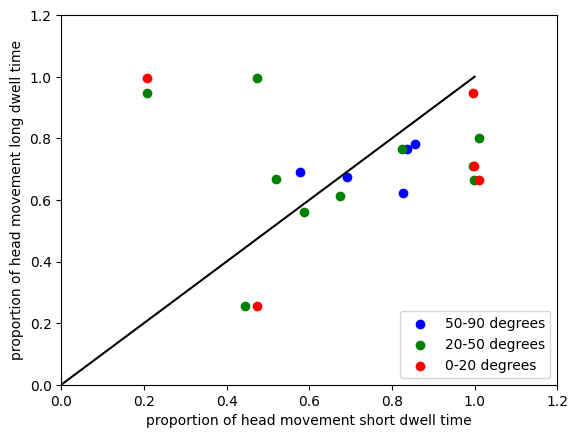

In [36]:
CHOR_long_List = []
CHOR_short_List = []
head_angle_distributions_short_list = []
head_angle_distributions_long_list = []
comparing = [2]
for cp in comparing:
    head_dir = all_head_data[cp]
    eye_dir = all_eye_data[cp]
    target_pos = all_target_data[cp]
    # prevent the angle from going to 360
    head_dir[:, 1:] = np.where(head_dir[:, 1:] > 180, head_dir[:, 1:] - 360, head_dir[:, 1:]) 
    eye_dir[:, 1:] = np.where(eye_dir[:, 1:] > 180, eye_dir[:, 1:] - 360, eye_dir[:, 1:])     
    
    neutral = np.array([0, 0, -1])
    target_dir = np.zeros(target_pos.shape)
    target_dir[:, 0] = target_pos[:, 0]
    for i in range(target_pos.shape[0]):
        # get the object rotation from scipy
        vec = target_pos[i, 1:]
        vec = vec / np.linalg.norm(vec)
        rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)
        # print(rot_y, target_dir[i, 2])
        target_dir[i, 2] = -rot_y

    # note the dispersion is originally for a 2D input array
    target_fixations, target_fixations_intervals = dispersion_filtering(target_dir[:, 0], target_dir[:, 1:], 0)
    target_fixations_angles = target_fixations[:, 1]
    target_fixation_duration = target_fixations[:, 2]

    # get the combined head and eye angles
    gaze_dir = eye_dir + head_dir
    gaze_fixations, gaze_fixations_intervals = dispersion_filtering(gaze_dir[:, 0], gaze_dir[:, 1:], 2)
    gaze_fixations_angles = gaze_fixations[:, 1]
    gaze_fixation_duration = gaze_fixations[:, 2]

    # get the target durations from the experimental setup file
    target_present_duration = all_target_input[cp]["duration"]
    valid_target_list = np.array(all_target_input[cp]["isTarget"])
    valid_target_list = np.where(valid_target_list==1, True, False)
    target_present_duration = np.array(target_present_duration)
    target_present_duration = target_present_duration[valid_target_list]

    head_fixation_angles, fixation_angles, fixation_duration = get_head_angles(head_dir, target_dir, target_fixations_intervals, target_fixation_duration, persistant_target_angle = dwellTimeTargets[np.maximum(cp-2, 0)])
    # fixation_angles = fixation_angles[1:]
    # head_fixation_angles = head_fixation_angles[1:]
    # fixation_duration = fixation_duration[1:]
    # target_present_duration = target_present_duration[1:] 

    sorted_indices = sorted(range(fixation_angles.shape[0]), key=lambda i: fixation_angles[i])

    # Rearrange array2 using the sorted indices
    head_fixation_angles_sorted = np.array([head_fixation_angles[i] for i in sorted_indices])
    fixation_angles_sorted = np.array([fixation_angles[i] for i in sorted_indices])
    fixation_duration_sorted = np.array([fixation_duration[i] for i in sorted_indices])
    target_present_duration_sorted = np.array([target_present_duration[i] for i in sorted_indices])

    is_short = np.where(target_present_duration_sorted < 0.6, True, False)
    is_long = np.where(target_present_duration_sorted >= 0.6, True, False)
    is_not_zero = np.where(np.abs(fixation_angles_sorted - dwellTimeTargets[0]) < 1E-3, False, True)
    is_short_and_is_not_zero = np.logical_and(is_short, is_not_zero)
    is_long_and_is_not_zero = np.logical_and(is_long, is_not_zero)
    CHOR_start_short, CHOR_end_short, target_angle_distribution_short, head_angle_distribution_short = get_CHOR(fixation_angles_sorted[is_short], head_fixation_angles_sorted[is_short], dwellTimeTargets[np.maximum(cp-2, 0)])
    CHOR_start_long, CHOR_end_long, target_angle_distribution_long, head_angle_distribution_long = get_CHOR(fixation_angles_sorted[is_long], head_fixation_angles_sorted[is_long], dwellTimeTargets[np.maximum(cp-2, 0)])
    
    CHOR_long_List.append([CHOR_start_long, CHOR_end_long])
    CHOR_short_List.append([CHOR_start_short, CHOR_end_short])

    head_angle_distributions_short_list.append(head_fixation_angles_sorted[is_short_and_is_not_zero])
    head_angle_distributions_long_list.append(head_fixation_angles_sorted[is_long_and_is_not_zero])

    # wilcoxon test on the head angle distribution for short and long dwell time -> this canot say that the two distributions are the same. We just failed to prove difference. 
    from scipy.stats import wilcoxon
    print(scipy.stats.wilcoxon(head_fixation_angles_sorted[is_short_and_is_not_zero], head_fixation_angles_sorted[is_long_and_is_not_zero]))
    
    # head contribution proportion
    head_contribution_proportion_short = head_fixation_angles_sorted[is_short_and_is_not_zero]/fixation_angles_sorted[is_short_and_is_not_zero]
    head_contribution_proportion_long = head_fixation_angles_sorted[is_long_and_is_not_zero]/fixation_angles_sorted[is_long_and_is_not_zero]
    plt.xlim([0, 1.2])
    plt.ylim([0, 1.2])
    is_low_range_short = np.where(np.abs(fixation_angles_sorted[is_short_and_is_not_zero]) <= 20, True, False)
    is_medium_range_short = np.where(np.abs(fixation_angles_sorted[is_short_and_is_not_zero]) <= 50, True, False)
    is_long_range_short = np.where(np.abs(fixation_angles_sorted[is_short_and_is_not_zero]) > 50, True, False)      
    is_low_range_long = np.where(np.abs(fixation_angles_sorted[is_long_and_is_not_zero]) <= 20, True, False)
    is_medium_range_long = np.where(np.abs(fixation_angles_sorted[is_long_and_is_not_zero]) <= 50, True, False)
    is_long_range_long = np.where(np.abs(fixation_angles_sorted[is_long_and_is_not_zero]) > 50, True, False)
    # print(head_contribution_proportion_short[is_long_range_short].shape, head_contribution_proportion_long[is_long_range_long].shape)
    plt.scatter(head_contribution_proportion_short[is_long_range_short], head_contribution_proportion_long[is_long_range_long], label="50-90 degrees", color="blue")
    plt.scatter(head_contribution_proportion_short[is_medium_range_short], head_contribution_proportion_long[is_medium_range_long], label="20-50 degrees", color="green")
    plt.scatter(head_contribution_proportion_short[is_low_range_short], head_contribution_proportion_long[is_low_range_long], label="0-20 degrees", color="red")
    plt.plot([0, 1], [0, 1], color="black")
    plt.xlabel("proportion of head movement short dwell time")
    plt.ylabel("proportion of head movement long dwell time")
    plt.legend()
    plt.show()

    doPlot = False
    if doPlot:
        plt.figure()
        plt.plot(head_angle_distribution_short[0], head_angle_distribution_short[1], label="head short")
        plt.plot(head_angle_distribution_long[0], head_angle_distribution_long[1], label="head long")
        plt.legend()
        plt.show()

        plt.figure()
        plt.plot(target_angle_distribution_short[0], target_angle_distribution_short[1], label="target short")
        plt.plot(target_angle_distribution_long[0], target_angle_distribution_long[1], label="target long")
        plt.legend()
        plt.show()

### plotting box plot comparison

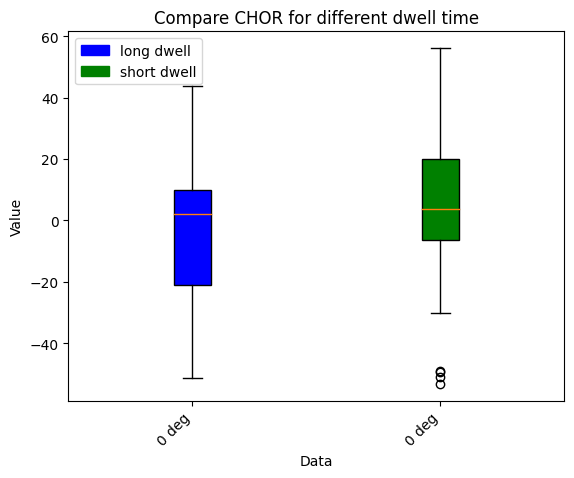

In [14]:
combined_data = [data_point for data_pair in zip(head_angle_distributions_long_list, head_angle_distributions_short_list) for data_point in data_pair]
long_dwell_title = ["{} deg".format(dwellTimeTargets[i]) for i in range(len(CHOR_long_List))]
short_dwell_title = ["{} deg".format(dwellTimeTargets[i]) for i in range(len(CHOR_short_List))]
combined_labels = [label for label_pair in zip(long_dwell_title, short_dwell_title) for label in label_pair]

# Customize the box colors
colors = ['blue', 'green']  # You can customize the colors
box = plt.boxplot(combined_data, labels=combined_labels, patch_artist=True)
for boxplot, color in zip(box['boxes'], colors * len(head_angle_distributions_long_list)):
    boxplot.set_facecolor(color)

# Create a legend
legend_labels = ['long dwell', 'short dwell']
legend_patches = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
plt.legend(legend_patches, legend_labels)
plt.xlabel('Data')
plt.ylabel('Value')
plt.title('Compare CHOR for different dwell time')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

# Plotting head contribution

In [473]:
# plot the head contribution to the target as a function of target angle
def plot_head_contribution_ratio(fixation_angles, head_fixations_angles, fixation_duration, target_present_duration):
    plt.figure(figsize=(10, 10))
    target_present_duration = np.array(target_present_duration)
    short_duration = np.where(target_present_duration <= 0.6, True, False)
    long_duration = np.where(target_present_duration > 0.6, True, False)

    # get subarray where short duration shows True
    plt.scatter(np.array(fixation_angles)[short_duration], np.array(head_fixations_angles)[short_duration], c="r", label="(short) head fixation closest value")
    plt.scatter(np.array(fixation_angles)[long_duration], np.array(head_fixations_angles)[long_duration], c="b", label="(long) head fixation closest value")
    
    # plt.scatter(fixation_angles, head_fixations_angles, c="b", label="(short) head fixation extreme value")
    plt.scatter(fixation_angles, fixation_angles, c="g", label="target angle")
    plt.legend()
    plt.xlabel("target angle")
    plt.ylabel("head angle")
    plt.title("Head contribution to target angle")
    plt.show()

    # plot ratio of head and target as a function of target duration
    relative_head_contribution = np.maximum(0, np.minimum(1, np.array(head_fixations_angles)/np.array(fixation_angles)))
    plt.figure(figsize=(10, 10))
    plt.scatter(target_present_duration, relative_head_contribution, c="r", label="relative ratio of head fixation (exteme value) and target angle)")
    # plt.scatter(non_zero_fixation_duration, np.array(head_fixations_value_held)/np.array(non_zero_fixation_angles), c="b", label="ratio of head fixation (value held) and target angle)")
    plt.legend()
    plt.xlabel("target duration")
    plt.ylabel("relative ratio of head fixation (exteme value) and target angle)")
    plt.show()

    plt.figure(figsize=(10, 10))
    absolute_head_contribution = np.abs(np.array(fixation_angles) - np.array(head_fixations_angles))
    plt.scatter(target_present_duration, absolute_head_contribution, c="r", label="absolute ratio of head fixation (exteme value) and target angle)")
    plt.legend()
    plt.xlabel("target duration")
    plt.ylabel("absolute ratio of head fixation (exteme value) and target angle)")
    plt.show()
plot_head_contribution_ratio(fixation_angles, head_fixations_angles, fixation_duration, target_present_duration=target_present_duration)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 79 but corresponding boolean dimension is 73

<Figure size 1000x1000 with 0 Axes>

## Plot and see

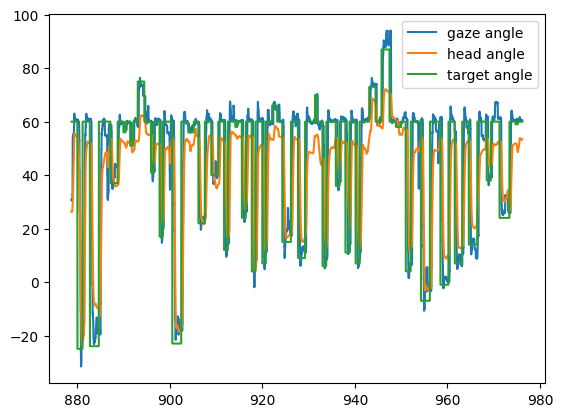

In [371]:
# plt.plot()
plt.cla()
plt.plot(eye_dir[:, 0], eye_dir[:, 2] + head_dir[:, 2], label="gaze angle")
plt.plot(eye_dir[:, 0], head_dir[:, 2], label="head angle")
plt.plot(target_dir[:, 0], target_dir[:, 2], label="target angle")
plt.legend()

In [372]:
# note the dispersion is originally for a 2D input array
target_fixations, target_fixations_intervals = dispersion_filtering(target_dir[:, 0], target_dir[:, 1:], 1)
target_fixations_angles = target_fixations[:, 1]
target_fixation_duration = target_fixations[:, 2]
# label targets as persistant

gaze_fixations, gaze_fixations_intervals = dispersion_filtering(eye_dir[:, 0], eye_dir[:, 1:])
gaze_fixations_angles = gaze_fixations[:, 1]
gaze_fixation_duration = gaze_fixations[:, 2]


71


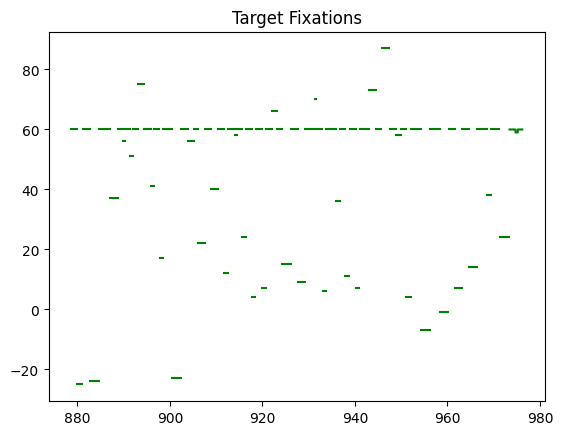

[[0, 92], [93, 172], [173, 286], [287, 425], [426, 605], [606, 717], [718, 806], [807, 839], [840, 911], [912, 957], [958, 1029], [1030, 1131], [1132, 1234], [1235, 1278], [1279, 1368], [1369, 1417], [1418, 1565], [1566, 1705], [1706, 1812], [1813, 1899], [1900, 1971], [1972, 2071], [2072, 2171], [2172, 2279], [2280, 2369], [2370, 2429], [2430, 2543], [2544, 2574], [2575, 2646], [2647, 2708], [2709, 2800], [2801, 2858], [2859, 2963], [2964, 3017], [3018, 3116], [3117, 3194], [3195, 3274], [3275, 3408], [3409, 3518], [3519, 3627], [3628, 3782], [3783, 3806], [3807, 3898], [3899, 3957], [3958, 4105], [4106, 4165], [4166, 4254], [4255, 4317], [4318, 4412], [4413, 4473], [4474, 4623], [4624, 4723], [4724, 4815], [4816, 4939], [4940, 5039], [5040, 5118], [5119, 5191], [5192, 5268], [5269, 5427], [5428, 5566], [5567, 5729], [5730, 5854], [5855, 5952], [5953, 6067], [6068, 6170], [6171, 6302], [6303, 6448], [6449, 6514], [6515, 6647], [6648, 6801], [6802, 7001]]


In [373]:
# print(len(target_fixations_intervals))
# print(len(gaze_fixations_intervals))
print(len(target_fixations_intervals))
temp = target_dir[target_fixations_intervals[0][0]:target_fixations_intervals[0][1]]
plt.plot(temp[:, 0], temp[:, 2])

# plot out all the fixation intervals to see if the dispersion base segmentation is working
# all the fixation intervals will be green colored lines, with title and a legend
# the head and gaze intervals are summed and plotted in blue. Each interval is plotted as a single line, represented by the most extreme angle
plt.cla()
for i in range(len(target_fixations_intervals)):
    temp = target_dir[target_fixations_intervals[i][0]:target_fixations_intervals[i][1]]
    plt.plot(temp[:, 0], temp[:, 2], color="green")

plt.title("Target Fixations")
plt.show()
print(target_fixations_intervals)
